In [1]:
import numpy as np
from rockpool.timeseries import TSEvent, TSContinuous

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

In [2]:
# [] TODO: change the import path
import sys
sys.path.insert(
    0,
    "/home/ugurc/SynSense Dropbox/Ugurcan Cakal/repos/rockpool__dynapse/rockpool/devices/dynapse",
)
from dpi_gui import ResponseGUI, SpikeParams
from utils import random_spike_train

10.0

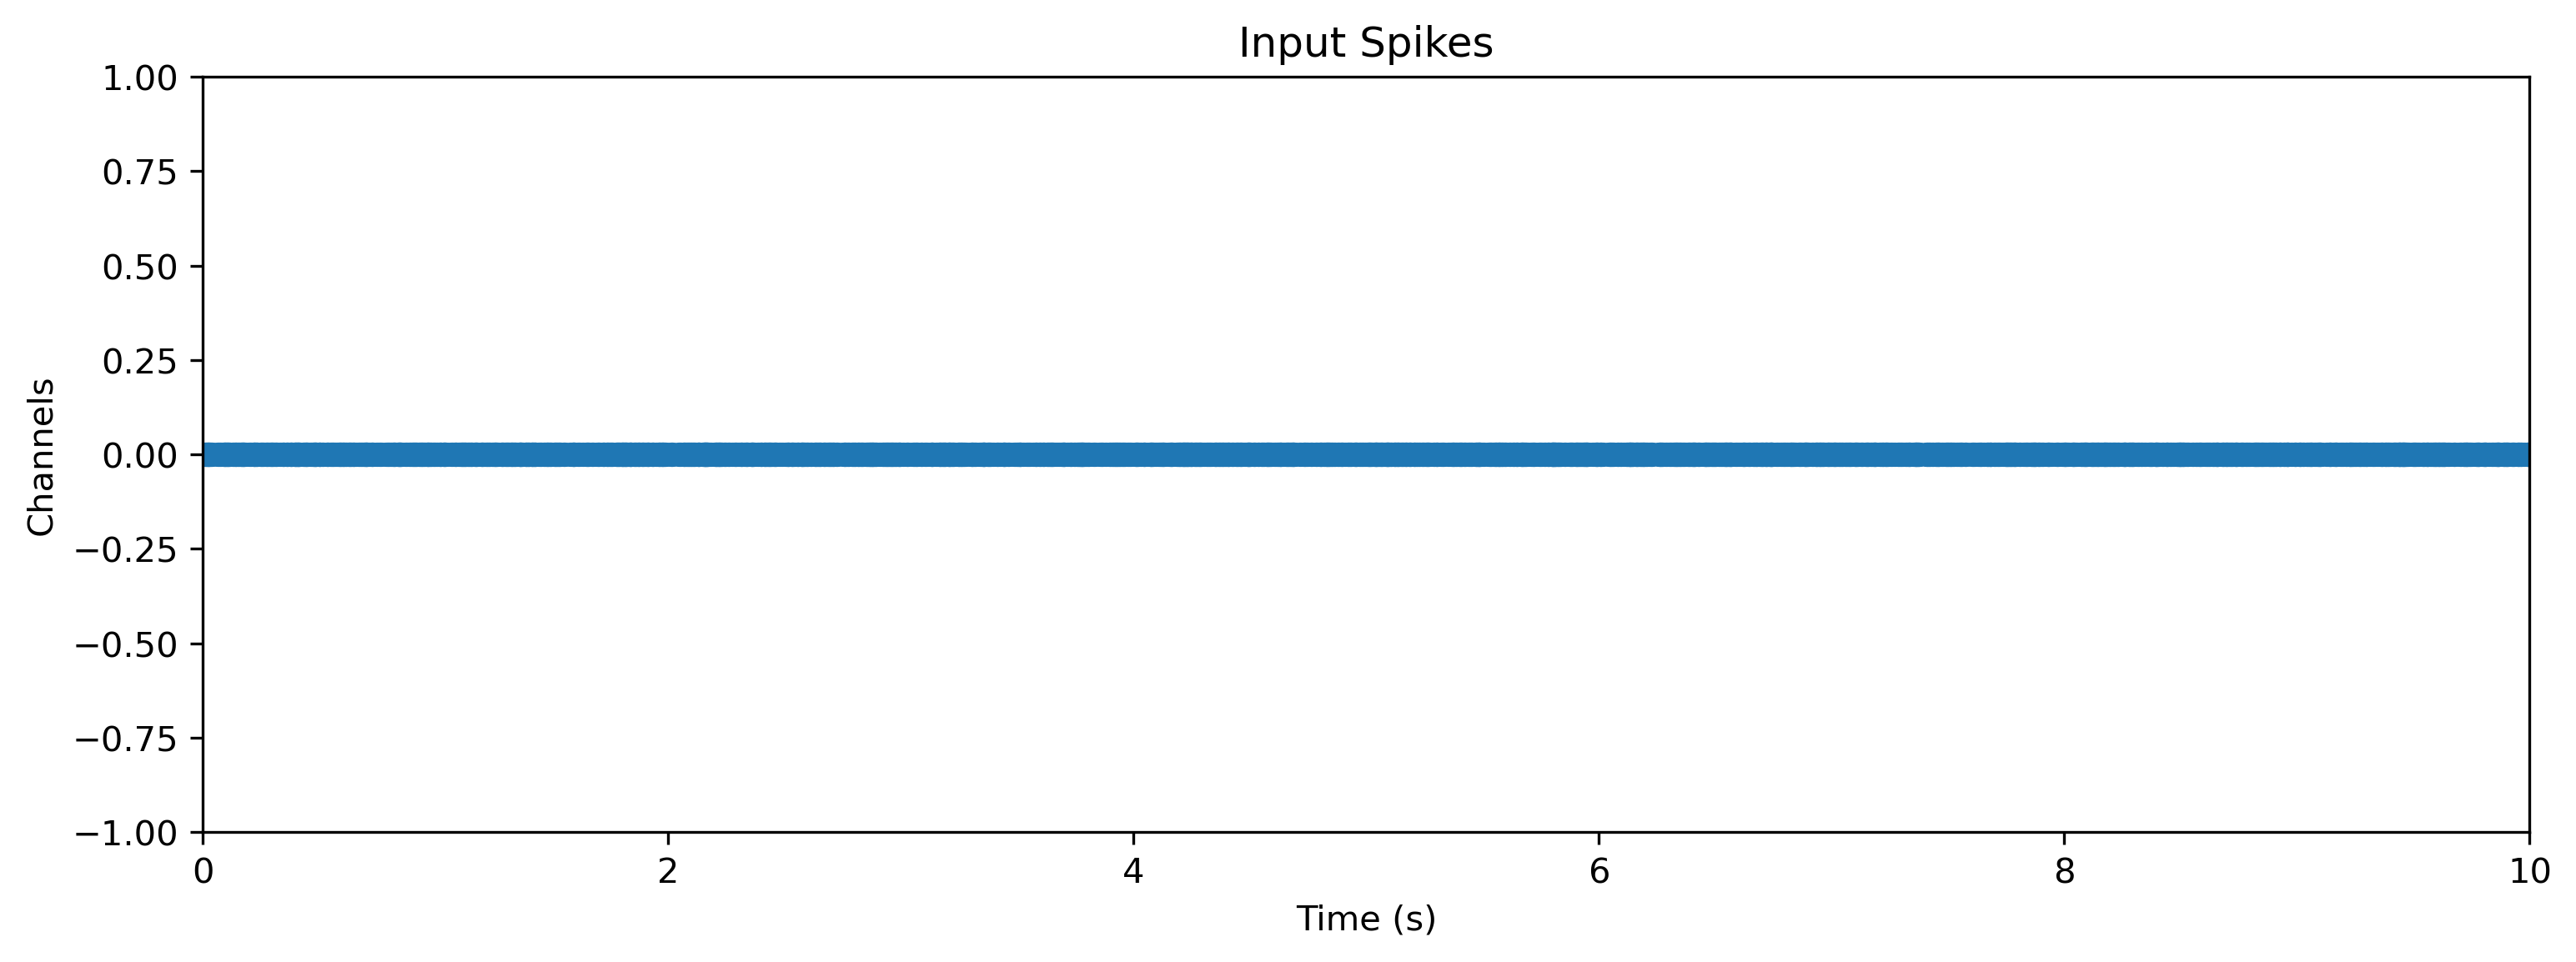

In [3]:
ts_spikes_random =  random_spike_train(
    duration = 10,
    n_channels = 1,
    rate = 200,
    dt = 1e-3,
    name = "Input Spikes"
)
ts_spikes_random.plot();
ts_spikes_random.duration

In [4]:
spike_params = SpikeParams(dt=1e-6)
res = ResponseGUI((1,), update_type='dpi', spike_params=spike_params, spike_in = ts_spikes_random)
res.display()

In [5]:
spike_params = SpikeParams(dt=1e-3)
res2 = ResponseGUI((1,), update_type='dpi_us', spike_params=spike_params, spike_in=ts_spikes_random)
res2.display()

In [6]:
rec1 = res.record_dict
rec2 = res2.record_dict

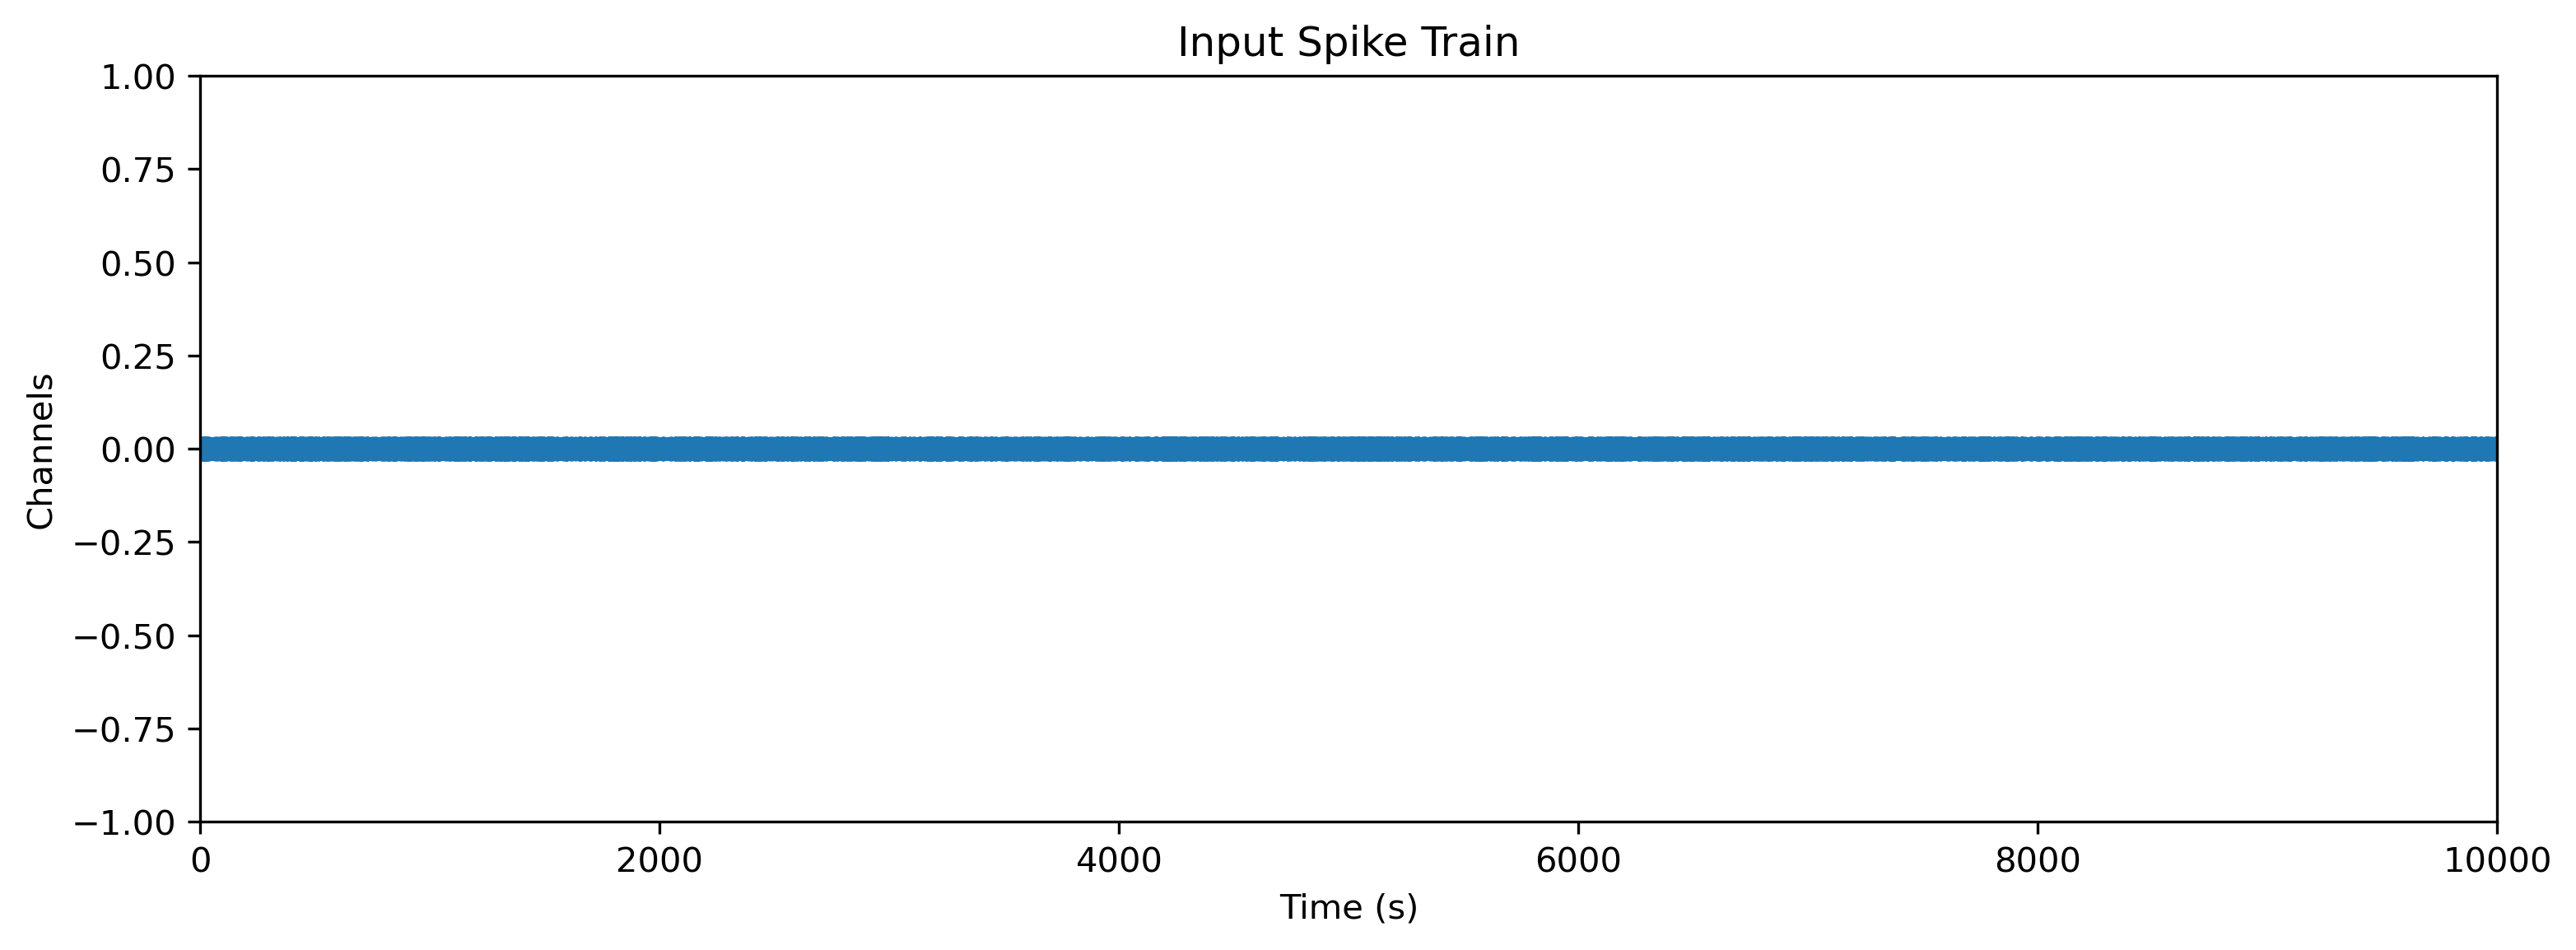

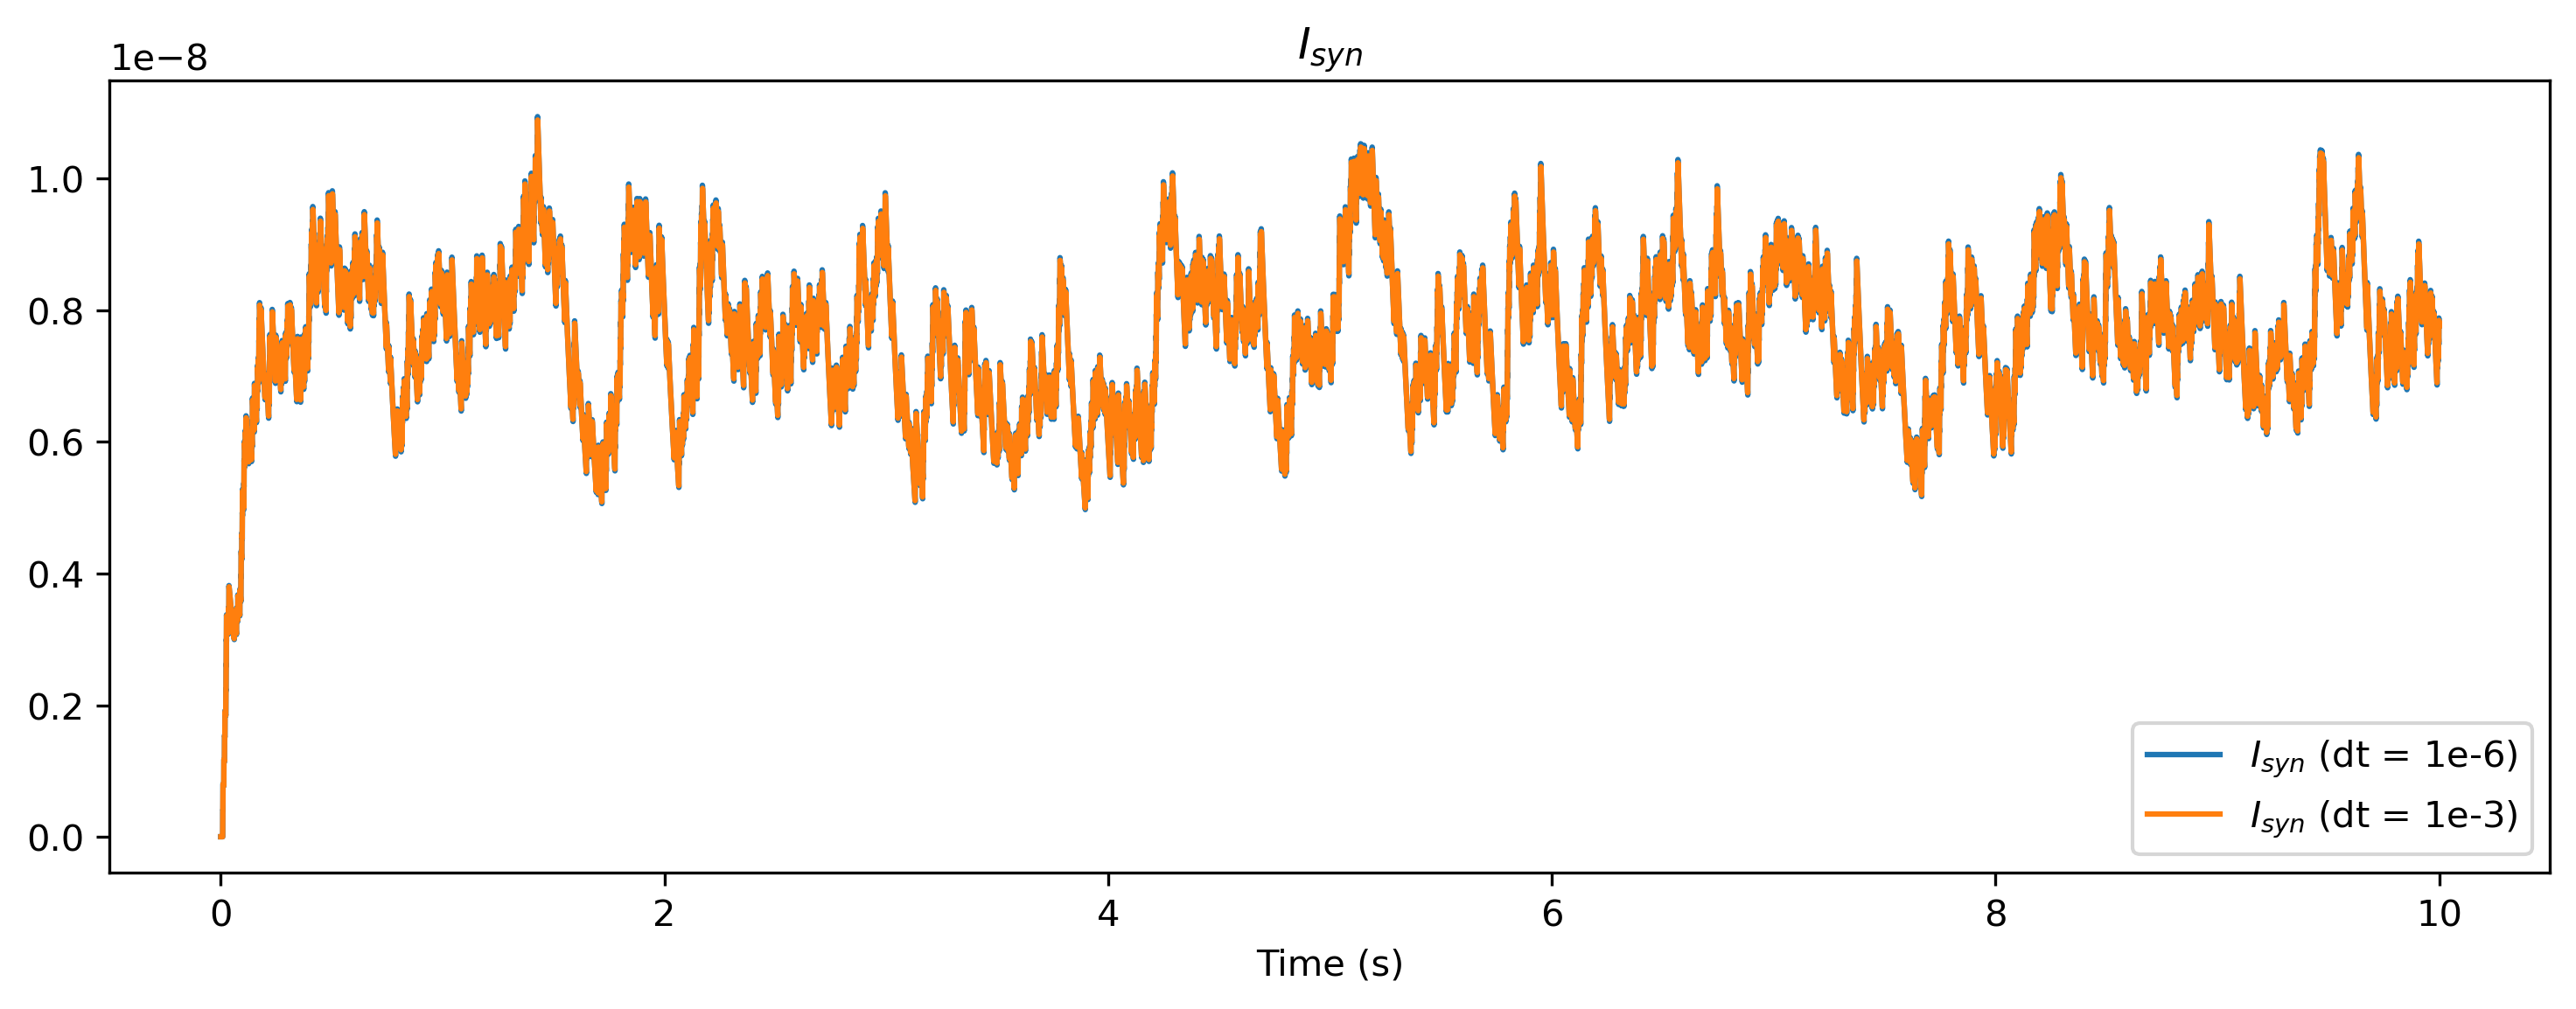

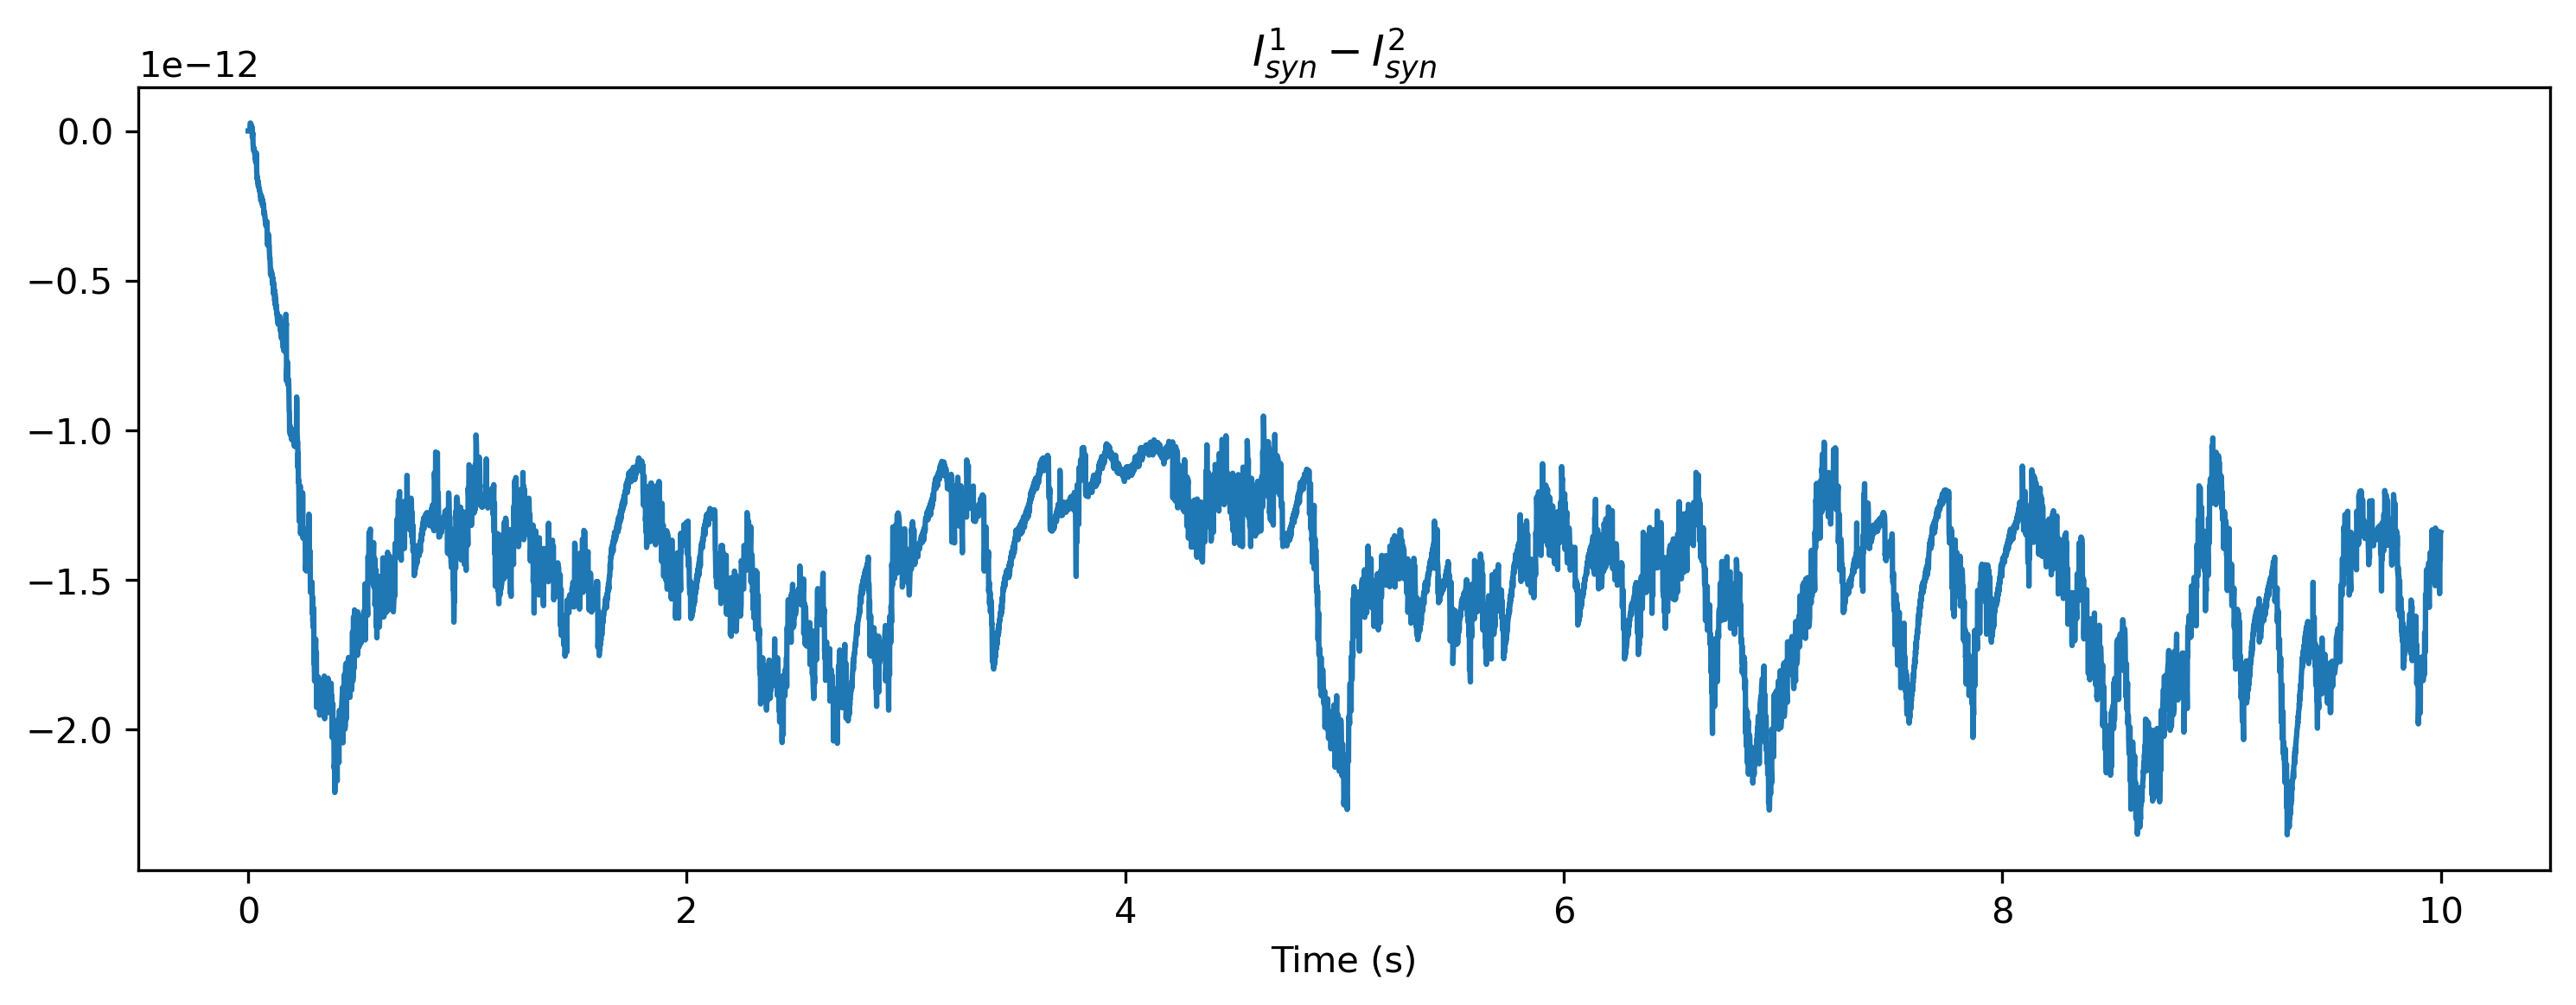

In [7]:
def compare_synaptic_responses(rd1, rd2, key='Inmda'):
    inp = TSEvent.from_raster(rec1['input_data'], dt = 1e-3, name = 'Input Spike Train')
    plt.figure()
    inp.plot()
    
    I_syn1 = TSContinuous.from_clocked(rd1[key], dt = 1e-6, name = '$I_{syn}$ (dt = 1e-6)')
    I_syn2 = TSContinuous.from_clocked(rd2[key], dt = 1e-3, name = '$I_{syn}$ (dt = 1e-3)')
    I_syn2 = I_syn2.start_at(1e-3)
    
    plt.figure()
    plt.title("$I_{syn}$")
    I_syn1.plot()
    I_syn2.plot()
    plt.legend()
    
    difference = rd1[key][999::1000] - rd2[key]
    diff = TSContinuous.from_clocked(difference, dt = 1e-3, name = '$I_{syn}^{1} - I_{syn}^{2}$')
    
    plt.figure()
    diff.plot()
    plt.show()
    
compare_synaptic_responses(rec1, rec2)